# Data Training
The training process is conducted using TensorFlow, with a convolutional neural network (CNN) model as the foundation. Hyperparameter tracking is managed through Weights & Biases (WandB), while model versioning is implemented via Hugging Face Hub. The initial model is developed using a vanilla CNN architecture, chosen for its simplicity and effectiveness in hypothetical scenarios.

### Import the necesary package

In [56]:
# handling paths
import os
# tracking the training hyperparameters and logs
import wandb
# custom script (store the data loading and preprocessing functions)
import utilities as ut
# handle data visualization
import matplotlib.pyplot as plt
# model versioning
from huggingface_hub import HfApi
# deep learning libraries for training the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adamax
from tensorflow.keras.callbacks import Callback, EarlyStopping

### Initialize the needed variables
initiate the variables to make the change of hyperparameter and configuration easier

In [57]:
# the path to the dataset
path_dataset = {
    "train": "./dataset/augmented_dataset/train",
    "test": "./dataset/splited_dataset/test",
}
# the hyperparameters of the model
hyperparameters = {
    "augmentation": True,
    "image_size": (128, 128),
    "batch_size": 64,
    "epochs": 20,
    "learning_rate": None,
    "optimizer": "adam",
    "loss": "sparse_categorical_crossentropy",
    "metrics": ["accuracy"],
    "model_structure": {
        "conv": 8,
        "pool": 4,
        "batchnorm": 4,
        "dropout": 8,
        "dense": 2},
}
# the optimizer map
optimizer_map = {
    "adam": Adam(),
    "sgd": SGD(),
    "rmsprop": RMSprop(),
    "adamax": Adamax(),
}
labels = os.listdir(path_dataset["train"])
commit_message = "experiment with model"
wandb_init_name = "experiment-with-model"

### Get the dataset
Load and preprocess the dataset using custom scripts

In [58]:
# get all the images path
path_imgs_train = ut.get_imgs_path(path_dataset["train"], labels)
path_imgs_test = ut.get_imgs_path(path_dataset["test"], labels)

In [59]:
# create the batched and already preprocessed dataset
trainset = ut.create_dataset(path_imgs_train, hyperparameters["image_size"], hyperparameters["batch_size"])
testset = ut.create_dataset(path_imgs_test, hyperparameters["image_size"], hyperparameters["batch_size"])

### Show the sample image
show the sample image from the batched datasett

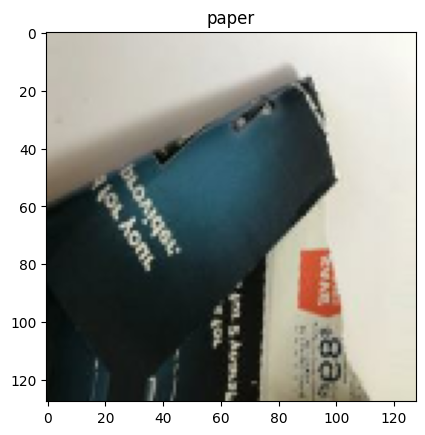

In [60]:
for img, label in trainset.take(1):
    plt.imshow(img[0].numpy())
    plt.title(labels[label[0]])
    plt.show()

### Connect wandb
initialize the wandb to connect and set the config to the current hyperparameters

In [61]:
wandb.init(project="trash-classification",
            name=wandb_init_name,
            config=hyperparameters)
config = wandb.config

### Create the model
the model is created from simple the complex. batch normalization is used to make the value more stable and dropout layer also added to help batch normalization prevent overfitting

In [62]:
model = Sequential([
    # conv layer 1
    Conv2D(16, (3, 3), activation="relu", input_shape=(config.image_size[0], config.image_size[1], 3)),
    # dropout layer
    Dropout(0.2),
    Conv2D(16, (3, 3), activation="relu"),
    # dropout layer
    Dropout(0.2),
    BatchNormalization(),
    MaxPool2D((2, 2)),

    # conv layer 2
    Conv2D(32, (3, 3), activation="relu"),
    # dropout layer
    Dropout(0.2),
    Conv2D(32, (3, 3), activation="relu"),
    # dropout layer
    Dropout(0.2),
    BatchNormalization(),
    MaxPool2D((2, 2)),

    # conv layer 3
    Conv2D(64, (3, 3), activation="relu"),
    # dropout layer
    Dropout(0.2),
    Conv2D(64, (3, 3), activation="relu"),
    # dropout layer
    Dropout(0.2),
    BatchNormalization(),
    MaxPool2D((2, 2)),

    # conv layer 4
    Conv2D(128, (3, 3), activation="relu"),
    # dropout layer
    Dropout(0.2),
    Conv2D(128, (3, 3), activation="relu"),
    # dropout layer
    Dropout(0.2),
    BatchNormalization(),
    MaxPool2D((2, 2)),

    Flatten(),
    # dense layer 1
    Dense(256, activation="relu"),
    Dense(256, activation="relu"),
    # dropout layer
    Dropout(0.2),
    # output layer
    Dense(len(path_imgs_train.label.unique()), activation="softmax")
])

### Model config
configure the model with the defined hyperparameter and create a wandb callback

In [63]:
model.compile(
    optimizer=optimizer_map[config.optimizer],
    loss=config.loss,
    metrics=config.metrics
)
class CustomWandbCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        wandb.log(logs)
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

### Model training
Train the model with test set as validationset

In [64]:
model.fit(
    trainset,
    validation_data=testset,
    epochs=config.epochs,
    callbacks=[CustomWandbCallback(), early_stopping]
)

Epoch 1/20
68/68 [==============================] - 54s 654ms/step - loss: 1.6319 - accuracy: 0.3243 - val_loss: 4.2627 - val_accuracy: 0.2092
Epoch 2/20
68/68 [==============================] - 47s 626ms/step - loss: 1.2945 - accuracy: 0.4672 - val_loss: 2.4087 - val_accuracy: 0.2490
Epoch 3/20
68/68 [==============================] - 47s 617ms/step - loss: 1.1694 - accuracy: 0.5416 - val_loss: 3.3963 - val_accuracy: 0.2019
Epoch 4/20
68/68 [==============================] - 48s 627ms/step - loss: 1.0668 - accuracy: 0.5897 - val_loss: 2.3365 - val_accuracy: 0.2019
Epoch 5/20
68/68 [==============================] - 53s 704ms/step - loss: 0.9814 - accuracy: 0.6209 - val_loss: 2.8419 - val_accuracy: 0.2008
Epoch 6/20
68/68 [==============================] - 48s 639ms/step - loss: 0.9029 - accuracy: 0.6509 - val_loss: 2.5656 - val_accuracy: 0.1695
Epoch 7/20
68/68 [==============================] - 46s 608ms/step - loss: 0.8385 - accuracy: 0.6901 - val_loss: 2.3862 - val_accuracy: 0.2897

### Save the model
The model is saved in form of .h5 and .keras. also, capture the log artifact

In [65]:
model.save("model/vanila_cnn.h5")
model.save("model/vanila_cnn.keras")
wandb.log_artifact("model/vanila_cnn.h5", type="model")
wandb.finish()

accuracy,▁▄▅▆▆▇███
loss,█▅▄▄▃▂▂▂▁
val_accuracy,▃▆▃▃▃▁█▄▂
val_loss,█▁▅▁▃▂▁▂▃
accuracy,0.71432
loss,0.7455
val_accuracy,0.17887
val_loss,2.76359


### Capture model version
upload the model to hugging face

In [66]:
api = HfApi()
repo = api.create_repo("trash-classification", repo_type="model", exist_ok=True)
api.upload_file(
    repo_id=repo.repo_id,
    path_or_fileobj="model/vanila_cnn.h5",
    path_in_repo="model/vanila_cnn.h5",
    repo_type=repo.repo_type,
    commit_message=f".h5 file - {commit_message}"
)
api.upload_file(
    repo_id=repo.repo_id,
    path_or_fileobj="model/vanila_cnn.keras",
    path_in_repo="model/vanila_cnn.keras",
    repo_type=repo.repo_type,
    commit_message=f".keras - {commit_message}"
)

vanila_cnn.h5: 100%|██████████| 10.8M/10.8M [00:08<00:00, 1.28MB/s]


CommitInfo(commit_url='https://huggingface.co/bugi-sulistiyo/trash-classification/commit/aefcd324847c42ae4be24028f94f16cfde119733', commit_message='.keras - experiment with model', commit_description='', oid='aefcd324847c42ae4be24028f94f16cfde119733', pr_url=None, repo_url=RepoUrl('https://huggingface.co/bugi-sulistiyo/trash-classification', endpoint='https://huggingface.co', repo_type='model', repo_id='bugi-sulistiyo/trash-classification'), pr_revision=None, pr_num=None)